<a href="https://colab.research.google.com/github/MasahiroAraki/MachineLearning/blob/master/Python/chap09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第9章 深層学習

ディープニューラルネットワークを用いて識別問題をコーディングします。Google ColabでGPUを使用するときは、「ランタイム」->「ランタイムのタイプを変更」-> ハードウェアアクセラレータ -> GPU を選びます。


深層学習用ラッパーライブラリ Keras は、ver3.0 からバックエンドとして TensorFlow, JAX, PyTorch が選べるマルチバックエンドになります。この notebook では、その pre-release である [Keras Core](https://github.com/keras-team/keras-core) でコーディングを行います。

事前のインストール

In [ ]:
!pip install keras-core transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.6 MB/s eta 0:00:00


## 畳み込みネットワークによる画像認識

## 準備

必要なライブラリ等を読み込みます。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras_core as keras

Using TensorFlow backend


## データの読み込み

fasion MNISTデータ（学習用60000事例、評価用10000事例、それぞれ28x28の行列）を使います。

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step       
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# 正解ラベル
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot']

<Figure size 640x480 with 0 Axes>

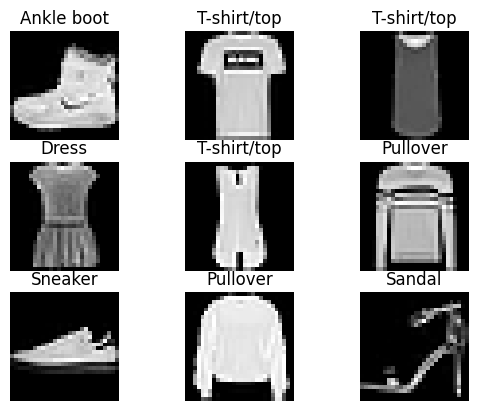

In [ ]:
# いくつかの画像を表示
plt.gray()
fig, axs = plt.subplots(3, 3)
for i in range(3):
  for j in range(3):
    axs[i,j].axis("off")
    axs[i,j].set_title(class_names[y_train[i*3+j]])
    axs[i,j].imshow(X_train[i*3+j])

入力を3次元テンソルから4次元テンソルに変換します。各次元は、データ数、縦のピクセル数、横のピクセル数、チャネル数（グレースケール画像は1）を表します。

In [ ]:
X_train = X_train.reshape(X_train.shape[0] , 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

値のとりうる範囲を0-255から0-1に変換します。

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

まず、通常の3階層ネットワークで学習・評価します。

In [ ]:
model1 = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ flatten (Flatten)                  │ (None, 784)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ (None, 128)                   │     100,480 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 10)                    │       1,290 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

損失関数の `sparse_categorical_crossentropy` は正解ラベルが整数で与えられているときに用います。one-hotベクトルで与えられている場合は `categorical_crossentropy`です。

In [ ]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

学習時の各エポックで検証用データを使ったスコアがログに記録されます。`validation_split` を設定すると、学習用データの中から指定した割合に応じて検証用データが作成されます。

In [ ]:
model1.fit(X_train, y_train, epochs=5, batch_size=200, validation_split=0.1)

Epoch 1/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7268 - loss: 0.8286 - val_accuracy: 0.8358 - val_loss: 0.4644
Epoch 2/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8495 - loss: 0.4359 - val_accuracy: 0.8540 - val_loss: 0.4104
Epoch 3/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8685 - loss: 0.3767 - val_accuracy: 0.8602 - val_loss: 0.3884
Epoch 4/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8777 - loss: 0.3482 - val_accuracy: 0.8555 - val_loss: 0.3842
Epoch 5/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8828 - loss: 0.3302 - val_accuracy: 0.8658 - val_loss: 0.3691


評価用データで性能を評価します

In [ ]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8613 - loss: 0.3871
Test accuracy: 0.8607


畳み込みネットワークで学習します。モデルのパラメータ数で構造を確認してください。

In [ ]:
model2 = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                  │ (None, 26, 26, 16)            │         160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_2 (MaxPooling2D)     │ (None, 13, 13, 16)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_3 (Conv2D)                  │ (None, 11, 11, 32)            │       4,640 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_3 (MaxPooling2D)     │ (None, 5, 5, 32)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_2 (Flatten)                │ (None, 800)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_4 (Dense)                    │ (None, 128)                   │     102,528 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_5 (Dense)                    │ (None, 10)                    │       1,290 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 108,618 (424.29 KB)

 Trainable params: 108,618 (424.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.fit(X_train, y_train, epochs=5, batch_size=200, validation_split=0.1)

Epoch 1/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6719 - loss: 0.9686 - val_accuracy: 0.8368 - val_loss: 0.4397
Epoch 2/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8481 - loss: 0.4251 - val_accuracy: 0.8667 - val_loss: 0.3727
Epoch 3/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8686 - loss: 0.3641 - val_accuracy: 0.8725 - val_loss: 0.3498
Epoch 4/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8818 - loss: 0.3284 - val_accuracy: 0.8875 - val_loss: 0.3124
Epoch 5/5
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8922 - loss: 0.2990 - val_accuracy: 0.8852 - val_loss: 0.3161


In [ ]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8870 - loss: 0.3294
Test accuracy: 0.8823


Dropoutを入れます。ユニットの半数が消えている状態で学習を行うので、epochは倍の回数をとります。

In [ ]:
model3 = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                  │ (None, 26, 26, 16)            │         160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_4 (MaxPooling2D)     │ (None, 13, 13, 16)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_5 (Conv2D)                  │ (None, 11, 11, 32)            │       4,640 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_5 (MaxPooling2D)     │ (None, 5, 5, 32)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 5, 5, 32)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_3 (Flatten)                │ (None, 800)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_6 (Dense)                    │ (None, 128)                   │     102,528 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 128)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_7 (Dense)                    │ (None, 10)                    │       1,290 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 108,618 (424.29 KB)

 Trainable params: 108,618 (424.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.1)

Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5508 - loss: 1.2364 - val_accuracy: 0.8155 - val_loss: 0.4998
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7835 - loss: 0.5817 - val_accuracy: 0.8457 - val_loss: 0.4285
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8149 - loss: 0.5065 - val_accuracy: 0.8533 - val_loss: 0.4046
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8289 - loss: 0.4675 - val_accuracy: 0.8678 - val_loss: 0.3624
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8451 - loss: 0.4313 - val_accuracy: 0.8752 - val_loss: 0.3442
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8492 - loss: 0.4207 - val_accuracy: 0.8782 - val_loss: 0.3315
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8578 - loss: 0.3968 - val_accuracy: 0.8852 - val_loss: 0.3192
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8574 - loss: 0.3883 - val_accuracy: 0.

評価用データで評価します。

In [ ]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8862 - loss: 0.3151
Test accuracy: 0.8855


## リカレントニューラルネットワークによる自然言語処理

IMDBデータは映画のレビューに対して、P/N(肯定/否定)のラベルが付いた学習データです。学習用に25000事例、評価用に25000事例用意されていて、PNの割合はそれぞれ50%です。
各レビューは単語列ではなく、単語インデックスの系列として表現されています。

ここでは、頻度上位10000語を対象とし、データの大きさは先頭の50単語に限定します。

## 準備

必要なライブラリ等を読み込みます。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras_core as keras

In [ ]:
max_features = 10000
maxlen = 50
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


単語インデックスを単語に戻して、元のデータを確認します。インデックスは"padding", "start of sequence","unknown"にそれぞれ0,1,2が割り当てられているので、3つずらして対応させます。

In [ ]:
word_index = keras.datasets.imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in X_train[0]])
decoded_review

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


"grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

単純なRNNを構成して学習させます。

In [ ]:
model1 = keras.Sequential([
    keras.layers.Embedding(max_features, 128),
    keras.layers.SimpleRNN(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding (Embedding)              │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ simple_rnn (SimpleRNN)             │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_8 (Dense)                    │ ?                             │ 0 (unbuilt) │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model1.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - acc: 0.6314 - loss: 0.6095 - val_acc: 0.7931 - val_loss: 0.4830
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - acc: 0.8700 - loss: 0.3154 - val_acc: 0.7741 - val_loss: 0.4704


In [ ]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.7721 - loss: 0.4840
Test accuracy: 0.7774


双方向LSTMを試します。

In [ ]:
model2 = keras.Sequential([
    keras.layers.Embedding(max_features, 128),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)            │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bidirectional (Bidirectional)      │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_9 (Dense)                    │ ?                             │ 0 (unbuilt) │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model2.fit(X_train, y_train, epochs=2, batch_size=32,validation_split=0.1)

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.7119 - loss: 0.5341 - val_acc: 0.8192 - val_loss: 0.3922
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.8786 - loss: 0.2896 - val_acc: 0.8153 - val_loss: 0.4197


In [ ]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.8115 - loss: 0.4258
Test accuracy: 0.8118


## 事前学習モデルを用いた識別

transformersライブラリを用いて、BERTでPN判定を行います。pipelineインスタンス作成時にタスクを与えると、デフォルトの設定が適用されます。また、モデルを与えると、そのモデルの設定が適用されます。あとは、そのインスタンスに入力を与えるだけで、結果が返却されます。

In [ ]:
from transformers import pipeline

nlp = pipeline('sentiment-analysis')

sentences = [
    "I love this movie, it's amazing and I had a great time.",  # ポジティブな文
    "I am having a bad experience with this story. It's borning." # ネガティブな文
]

for sentence in sentences:
    result = nlp(sentence)
    print(f"Text: {sentence}")
    print(f"Sentiment: {result}\n")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Text: I love this movie, it's amazing and I had a great time.
Sentiment: [{'label': 'POSITIVE', 'score': 0.9998825788497925}]

Text: I am having a bad experience with this story. It's borning.
Sentiment: [{'label': 'NEGATIVE', 'score': 0.9997226595878601}]



## 練習問題

1. 畳み込みネットワークにおいて、使用するデータをCIFER10 (https://keras.io/ja/datasets/) に変更し、いくつかのネットワーク構造について認識・評価を行ってください。

1. リカレントニューラルネットワークにおいて、使用するデータを[ロイターのニュースワイヤー](https://keras.io/api/datasets/reuters/)に変更し、いくつかのネットワーク構造について認識・評価を行ってください。

1. 事前学習モデルを使って、日本語の感情分析を行ってください。

### 練習問題1の解答例



## 準備

必要なライブラリ等を読み込みます。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras_core as keras

CIFER10は画像認識用のデータセットです。10種類のカテゴリの画像が含まれています。

In [ ]:
cf10 = keras.datasets.cifar10
(X_train,y_train),(X_test,y_test)=keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


学習用データは50000枚の32x32画像で、カラーなので3チャンネルからなります。

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
target_names =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

学習用データからランダムに25枚を表示します。

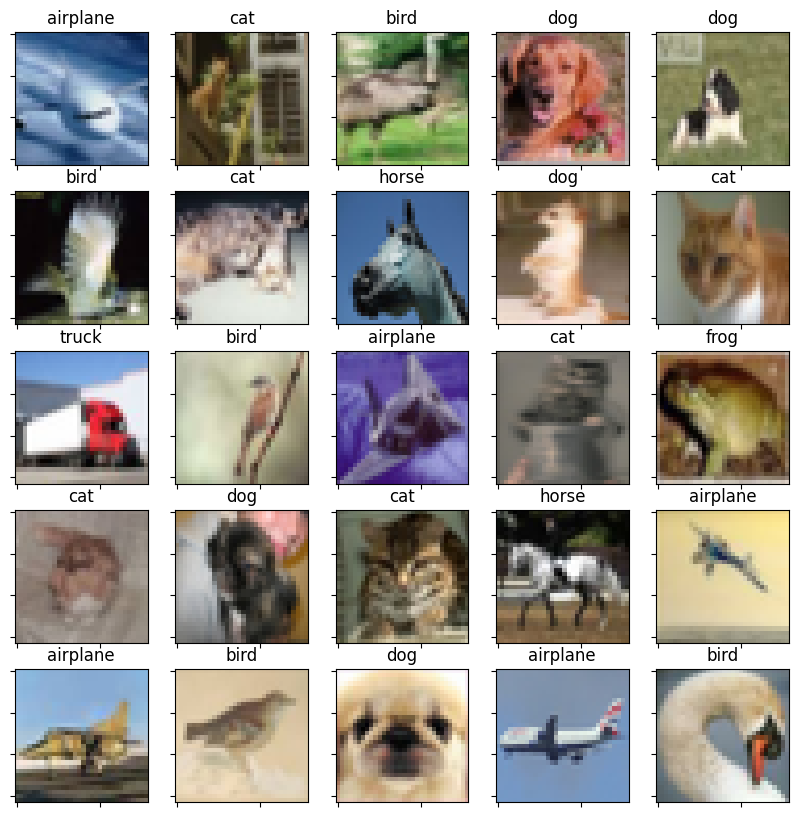

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    rand_num = np.random.randint(0,X_train.shape[0])
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[rand_num])
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.title(target_names[y_train[rand_num][0]])
plt.show()

入力値を0～1に、出力をone-hotベクトルにします。

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

単純なCNNで認識してみます。

In [ ]:
model1 = keras.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                  │ (None, 30, 30, 32)            │         896 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_4 (MaxPooling2D)     │ (None, 15, 15, 32)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_5 (Conv2D)                  │ (None, 13, 13, 32)            │       9,248 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_5 (MaxPooling2D)     │ (None, 6, 6, 32)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_3 (Flatten)                │ (None, 1152)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_8 (Dense)                    │ (None, 128)                   │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_9 (Dense)                    │ (None, 10)                    │       1,290 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 159,018 (621.16 KB)

 Trainable params: 159,018 (621.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3483 - loss: 1.8002
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5270 - loss: 1.3391
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5862 - loss: 1.1747
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6230 - loss: 1.0880
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6516 - loss: 0.9998


In [ ]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6370 - loss: 1.0402
Test accuracy: 0.6352999806404114


バッチ標準化とドロップアウトを入れてみます。ドロップアウトでは半数のユニットが消えているので、epochは倍の回数をとります。

In [ ]:
model2 = keras.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                  │ (None, 30, 30, 32)            │         896 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_6 (MaxPooling2D)     │ (None, 15, 15, 32)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization                │ (None, 15, 15, 32)            │         128 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_2 (Dropout)                │ (None, 15, 15, 32)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_7 (Conv2D)                  │ (None, 13, 13, 32)            │       9,248 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_7 (MaxPooling2D)     │ (None, 6, 6, 32)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_4 (Flatten)                │ (None, 1152)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_10 (Dense)                   │ (None, 128)                   │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_11 (Dense)                   │ (None, 10)                    │       1,290 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 159,146 (621.66 KB)

 Trainable params: 159,082 (621.41 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.1)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3023 - loss: 1.9850
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4980 - loss: 1.4009
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5259 - loss: 1.3264
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5682 - loss: 1.2146
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5912 - loss: 1.1539
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6136 - loss: 1.0983
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6215 - loss: 1.0695
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6358 - loss: 1.0321
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6513 - loss: 0.9990
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6558 - loss: 0.9709


In [ ]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6014 - loss: 1.1372
Test accuracy: 0.6032000184059143


### 練習問題2の解答例


## 準備

必要なライブラリ等を読み込みます。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras_core as keras

In [ ]:
max_features = 10000
maxlen = 50
(X_train, y_train), (X_test, y_test) = keras.datasets.reuters.load_data(num_words=max_features)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       


単語インデックスを単語に戻して、元のデータを確認します。インデックスは"padding", "start of sequence","unknown"にそれぞれ0,1,2が割り当てられているので、3つずらして対応させます。

In [ ]:
word_index = keras.datasets.reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in X_train[0]])
decoded_review

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       


'company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [ ]:
y_train = keras.utils.to_categorical(y_train, 46)
y_test = keras.utils.to_categorical(y_test, 46)

単純なRNNを構成して学習させます。

In [ ]:
model3 = keras.Sequential([
    keras.layers.Embedding(max_features, 128),
    keras.layers.SimpleRNN(64),
    keras.layers.Dense(46, activation='softmax')
])
model3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)            │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ simple_rnn_1 (SimpleRNN)           │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_12 (Dense)                   │ ?                             │ 0 (unbuilt) │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model3.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - acc: 0.3349 - loss: 2.6730 - val_acc: 0.4190 - val_loss: 2.4528
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - acc: 0.4684 - loss: 2.0751 - val_acc: 0.4624 - val_loss: 1.9549
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.6338 - loss: 1.4817 - val_acc: 0.4736 - val_loss: 1.9607
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.7647 - loss: 1.0122 - val_acc: 0.4780 - val_loss: 2.0840
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8544 - loss: 0.6724 - val_acc: 0.4691 - val_loss: 2.1820


In [ ]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.4883 - loss: 2.0804
Test accuracy: 0.4741763174533844


bi-LSTMに変更します。

In [ ]:
model4 = keras.Sequential([
    keras.layers.Embedding(max_features, 128),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(46, activation='softmax')
])
model4.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)            │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bidirectional_1 (Bidirectional)    │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_13 (Dense)                   │ ?                             │ 0 (unbuilt) │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model4.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - acc: 0.3854 - loss: 2.5708 - val_acc: 0.5470 - val_loss: 1.7106
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.5730 - loss: 1.5963 - val_acc: 0.6188 - val_loss: 1.5238
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.6622 - loss: 1.2694 - val_acc: 0.6477 - val_loss: 1.4068
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.7323 - loss: 1.0141 - val_acc: 0.6500 - val_loss: 1.3796
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.7901 - loss: 0.8199 - val_acc: 0.6483 - val_loss: 1.4236


In [ ]:
test_loss, test_acc = model4.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.6451 - loss: 1.5091
Test accuracy: 0.6322351098060608


### 練習問題3の回答

In [ ]:
from transformers import pipeline

nlp = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

sentences = [
    "この映画は大好きで、素晴らしくて、とても楽しかった。",  # ポジティブな文
    "この物語は嫌いだ。つまらない。" # ネガティブな文
]

for sentence in sentences:
    result = nlp(sentence)
    print(f"Text: {sentence}")
    print(f"Sentiment: {result}\n")

Text: この映画は大好きで、素晴らしくて、とても楽しかった。
Sentiment: [{'label': 'positive', 'score': 0.9550613164901733}]

Text: この物語は嫌いだ。つまらない。
Sentiment: [{'label': 'negative', 'score': 0.8958940505981445}]

